In [1]:
import numpy as np
import random

In [2]:
patch_net = {0: {'Name': 'Roost', 'carrying_capacity': 1, 'init_resources': 0, 'resource_birth': 0,
                 'patch_center': [0.5,0.5], 'bat_resource_conversion': 0, 'Res':np.array([0,0])},
             1: {'Name': 'Residential', 'carrying_capacity': 1000, 'init_resources': 1000, 'resource_birth': 0.05,
                 'patch_center': [1.5,0.5], 'bat_resource_conversion': 0.9, 'Res':np.array([0,1])},
             2: {'Name': 'Residential 2', 'carrying_capacity': 1000, 'init_resources': 1000, 'resource_birth': 0.05,
                 'patch_center': [2.5,0.5], 'bat_resource_conversion': 0.9, 'Res':np.array([0,1])},
             3: {'Name': 'Orchard', 'carrying_capacity': 1000, 'init_resources': 1000, 'resource_birth': 0.01,
                 'patch_center': [0.5,1.5], 'bat_resource_conversion': 0.9, 'Res':np.array([1,0])},
             4: {'Name': 'Orchard 2', 'carrying_capacity': 1000, 'init_resources': 1000, 'resource_birth': 0.01,
                 'patch_center': [1.5,1.5], 'bat_resource_conversion': 0.9, 'Res':np.array([1,0])},
             5: {'Name': 'Dump', 'carrying_capacity': 500, 'init_resources': 100, 'resource_birth': 0.5,
                 'patch_center': [2.5,1.5], 'bat_resource_conversion': 0.9, 'Res':np.array([0,1])}}

In [3]:
patch_types = ['Roost','Forest']#['Roost', 'Residential', 'Orchard', 'Water Body', 'Forest', 'Dump']
patch_names = random.choices(patch_types,weights = [1/100,99/100],k=100)#[1/100, 20/100, 10/100,10/100,50/100, 9/100], k = 100)
while 'Roost' not in patch_names:
    patch_names = random.choices(patch_types,weights = [1/100,99/100],k=100)#[1/100, 20/100, 10/100,10/100,50/100, 9/100], k = 100)

In [4]:
#create patch network that is 10x10

patch_net_10x10 = {}
resources = np.zeros((10,10))
count = 0
K = np.random.choice(np.arange(1,500))
rb = 0#np.random.choice(np.arange(0,0.1,0.001))

for i in range(10):
    for j in range(10):
        patch_net_10x10[count] ={}
        patch_net_10x10[count]['Name']= patch_names[count]
        patch_net_10x10[count]['patch_center']= [i+0.5,j+0.5]
        patch_net_10x10[count]['carrying_capacity']= K
        patch_net_10x10[count]['init_resources']= np.random.choice(np.arange(1,K+1))
        resources[i,j]=patch_net_10x10[count]['init_resources']
        patch_net_10x10[count]['resource_birth'] = rb
        if patch_net_10x10[count]['Name'] in ['Residential','Dump']:
            patch_net_10x10[count]['Res']=np.array([0,1])
        elif patch_net_10x10[count]['Name'] in ['Orchard', 'Water Body', 'Forest']:
            patch_net_10x10[count]['Res']=np.array([1,0])
        else:
            patch_net_10x10[count]['Res']=np.array([0.5,0.5])
        count = count+1
            
            

In [5]:
import pickle 

with open('test_small_synth_patch_net.pkl', 'wb') as f:
    pickle.dump(patch_net_10x10, f)


In [9]:
rb

0

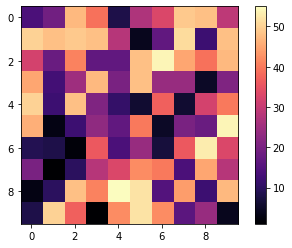

In [6]:
import matplotlib.pyplot as plt
data=np.array(resources)
plt.imshow(data,cmap='magma')
plt.colorbar()
plt.show()

In [7]:
print(np.mean(resources))
print(np.max(resources))

28.85
55.0


In [8]:
patch_type_dist = np.zeros(len(patch_types))
for p in patch_names:
    if p=='Roost':
        patch_type_dist[0]+=1
    if p=='Residential':
        patch_type_dist[1]+=1
    if p=='Orchard':
        patch_type_dist[2]+=1
    if p=='Water Body':
        patch_type_dist[3]+=1
    if p=='Forest':
        patch_type_dist[4]+=1
    if p=='Dump':
        patch_type_dist[5]+=1

patch_probs = np.array([0.        , 0.53710742, 0.26605321, 0.06561312, 0.06561312,
       0.06561313])

patch_dist = np.zeros(len(patch_names))
count = 0
for p in patch_names:
    if p=='Roost':
        patch_dist[count]=0
    if p=='Residential':
        patch_dist[count]=patch_probs[1]/patch_type_dist[1]
    if p=='Orchard':
        patch_dist[count]=patch_probs[2]/patch_type_dist[2]
    if p=='Water Body':
        patch_dist[count]=patch_probs[3]/patch_type_dist[3]
    if p=='Forest':
        patch_dist[count]=patch_probs[4]/patch_type_dist[4]
    if p=='Dump':
        patch_dist[count]=patch_probs[5]/patch_type_dist[5]
    count = count+1

IndexError: index 4 is out of bounds for axis 0 with size 2

In [ ]:
with open('init_small_synth_forage.pkl', 'wb') as f:
    pickle.dump(patch_dist, f)